<a href="https://colab.research.google.com/github/ameernayman/Sensitive_image_classification/blob/main/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sensitive Data classification for text

##  This model run in google colab https://colab.research.google.com/

In [83]:
import tensorflow as tf
import json
import os
import random
import numpy

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [84]:

text_folder = "/content/Sensitive_image_classification"
if os.path.exists(text_folder) == False:
  !git clone https://github.com/ameernayman/Sensitive_image_classification.git

dataset_text = text_folder + "/dataset_text/"
sensitive_json = "data_sensitive.json"
nonsensitive_json = "data_nonsensitive.json"

### Text model Preprocessing the dataset

In [85]:
textData = []
textSentences = []
textLabels = []
size_training = 20000
stopwords_text = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

def load_data(filename):
  with open(dataset_text + filename, 'r') as f:
      data_store = json.load(f)
  for value in data_store:
    textSentences = value['data']
    textLabels = value['is_sensitive']
    for wrd in stopwords_text: 
      token = " " + wrd + " "
      textSentences = textSentences.replace(token, " ")
    textData.append([textSentences, textLabels])


load_data(sensitive_json)
load_data(nonsensitive_json)

random.shuffle(textData)


for item in textData:
  textSentences.append(item[0])
  textLabels.append(item[1])


training_snt_text= textSentences[0:size_training]
validation_snt_text = textSentences[size_training:]
training_lbls_text = textLabels[0:size_training]
validation_lbls_text = textLabels[size_training:]

print("Size of Training Data set is: ", len(training_snt_text))
print("Training Data Sample:", training_snt_text[0])
print("Size of Validation Data set is: ", len(validation_snt_text))
print("Validation Sample:", validation_snt_text[0])

Size of Training Data set is:  20000
Training Data Sample: Arden Stuart (Greta Garbo) believes single standard conduct apply sexes. She strives combination freedom, equality, honesty love. Her first attempt chauffeur Anthony Kendall, secretly disillusioned "ace aviator" son lord. However romance ends disaster; commits suicide fired it.
Her longtime admirer Tommy Hewlett (Johnny Mack Brown) wants marry her, Arden finds fulfillment chance encounter Packy Cannon (Nils Asther), wealthy ex-prizefighter turned painter. He planned cruise South Seas yacht alone, impulsively goes him. After months idyllic bliss however, turns around takes home, explaining needs full attention painting.
Though Tommy knows Arden's love Packy, begs marry anyway. She agrees. Several years go by, much-beloved son.
However, Packy returns admits Arden not stop thinking her. She swept away agrees sail away him. Tommy confronts rival gun; orders Packy pretend reject Arden, promising arrange hunting "accident" himself, A

# Creating training, validation sequence and labels 

In [86]:

type_trunc='post'
padding='post'
out_of_vocb = "<OOV>"

length_text = 60
size_vocab = 3000
tknizer = Tokenizer(num_words=size_vocab, oov_token=out_of_vocb)

tknizer.fit_on_texts(training_snt_text)

index_words = tknizer.word_index
print("Size of word index:", len(index_words))

with open("word_index.json", "w") as outfile:  
    json.dump(index_words, outfile)
    print("Saving the word index as JSON")


training_squnce = tknizer.texts_to_sequences(training_snt_text)
padding_Tdataset = pad_sequences(training_squnce, maxlen=length_text, padding=padding, truncating=type_trunc)


validation_squnce = tknizer.texts_to_sequences(validation_snt_text)
padding_Vdataset = pad_sequences(validation_squnce, maxlen=length_text, padding=padding, truncating=type_trunc)
padding_Tdataset = numpy.array(padding_Tdataset)
training_lbls_text = numpy.array(training_lbls_text)
padding_Vdataset = numpy.array(padding_Vdataset)
validation_lbls_text = numpy.array(validation_lbls_text)

Size of word index: 102383
Saving the word index as JSON


## Sequential Model Using Conv1D, GlobalPooling, and with Dense layer

In [87]:

dimensions = 32
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(size_vocab, dimensions, input_length=length_text),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 60, 32)            96000     
                                                                 
 conv1d_10 (Conv1D)          (None, 56, 64)            10304     
                                                                 
 global_average_pooling1d_10  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_20 (Dense)            (None, 24)                1560      
                                                                 
 dense_21 (Dense)            (None, 1)                 25        
                                                                 
Total params: 107,889
Trainable params: 107,889
Non-trainable params: 0
_______________________________________________

# Callback function to aviod overfitting

In [88]:

ACCURACY = 0.99
class myEpoch(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > ACCURACY:
      print(" Accurracy is 0.99 then cancel the epoch")
      self.model.stop_training = True

epoch_callbacks = myEpoch()


## Valdation and Training model fitting


In [89]:
no_epochs = 10


history = model.fit(padding_Tdataset, 
                    training_lbls_text, 
                    epochs=no_epochs, 
                    validation_data=(
                        padding_Vdataset, 
                        validation_lbls_text), 
                    verbose=1)
                    #callbacks=[epoch_callbacks])

Epoch 1/10
625/625 [==============================] - 8s 11ms/step - loss: 0.0515 - accuracy: 0.9916 - val_loss: 0.0032 - val_accuracy: 0.9987
Epoch 2/10
625/625 [==============================] - 7s 11ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 4.6975e-04 - val_accuracy: 0.9999
Epoch 3/10
625/625 [==============================] - 7s 11ms/step - loss: 3.6711e-04 - accuracy: 0.9998 - val_loss: 1.2423e-04 - val_accuracy: 1.0000
Epoch 4/10
625/625 [==============================] - 7s 11ms/step - loss: 1.2804e-04 - accuracy: 0.9999 - val_loss: 4.9642e-05 - val_accuracy: 1.0000
Epoch 5/10
625/625 [==============================] - 6s 10ms/step - loss: 5.3410e-05 - accuracy: 1.0000 - val_loss: 2.8037e-05 - val_accuracy: 1.0000
Epoch 6/10
625/625 [==============================] - 7s 11ms/step - loss: 2.7080e-05 - accuracy: 1.0000 - val_loss: 1.9742e-05 - val_accuracy: 1.0000
Epoch 7/10
625/625 [==============================] - 7s 11ms/step - loss: 1.3297e-05 - accuracy: 1.0000 -

## Plotting Accuracy and Loss graph for Text Model

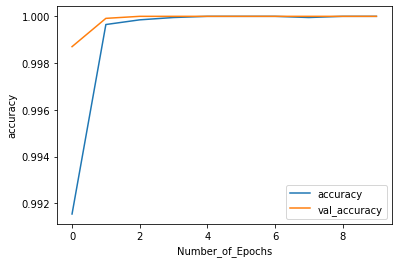

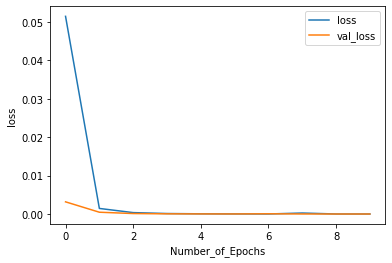

In [90]:
import matplotlib.pyplot as plot


def graphsPlot(history, str):
  plot.plot(history.history[str])
  plot.plot(history.history['val_'+str])
  plot.xlabel("Number_of_Epochs")
  plot.ylabel(str)
  plot.legend([str, 'val_'+str])
  plot.show()
  
graphsPlot(history, "accuracy")
graphsPlot(history, "loss")

# Ploting the Confusion Matrix

Accuracy for 8682 Test Data =  100.0
Accuracy for 11576 Test Data =  100.0
Accuracy for 14470 Test Data =  100.0
Accuracy for 17364 Test Data =  100.0


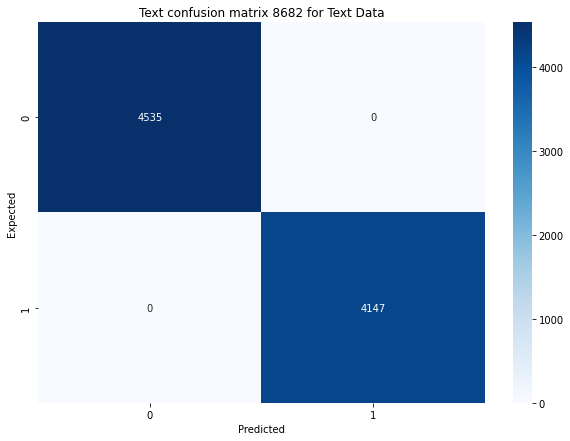

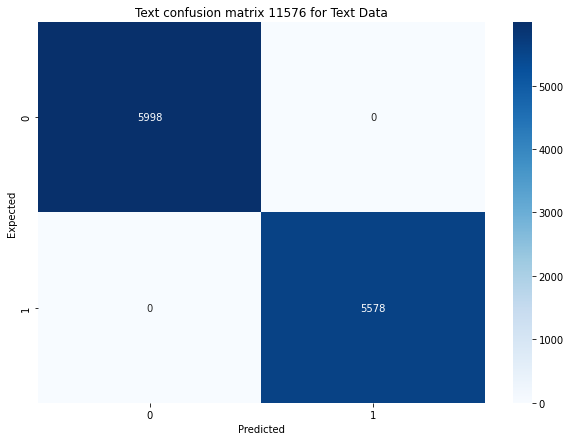

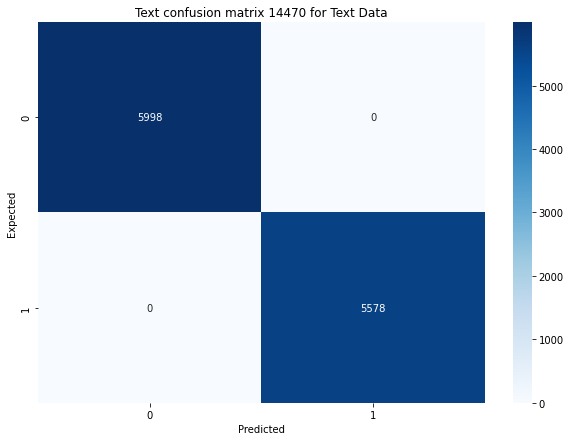

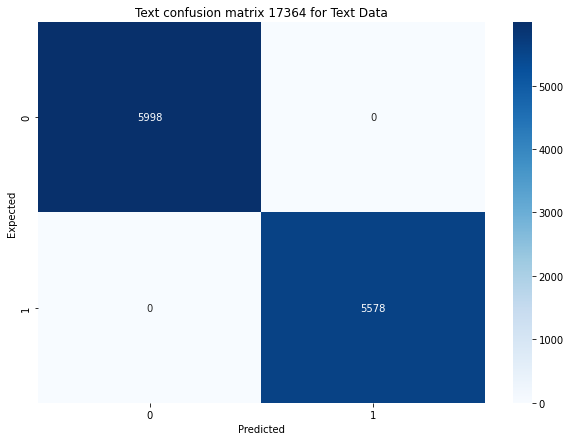

In [91]:
import seaborn

text_predicted = model.predict(padding_Vdataset)
predicted_text_labels = text_predicted > 0.5

size = numpy.size(predicted_text_labels)
predicted_text_labels = predicted_text_labels.reshape(size, )

for num in range (3, 7):
  count = num * size // 4
  text_matrix = tf.math.confusion_matrix(labels=validation_lbls_text[0:count],predictions=predicted_text_labels[0:count])

  confusion_matrix = text_matrix.numpy()
  conf_acc = (confusion_matrix[0, 0] + confusion_matrix[1, 1])/ numpy.sum(confusion_matrix) * 100
  print("Accuracy for", str(count), "Test Data = ", conf_acc)

  plot.figure(figsize = (10,7))
  seaborn.heatmap(text_matrix, annot=True, fmt='d', cmap='Blues')
  plot.title("Text confusion matrix " + str(count) + " for Text Data")
  plot.xlabel('Predicted')
  plot.ylabel('Expected')

## Experiment

In [92]:

list_sntnc = ["My name is Ameer Hussain Nayman", "Ronaldo scored fantasic goals","congratulations, I got a job", "I need to run my errands"]
txt_seq = tknizer.texts_to_sequences(list_sntnc)
text_pad = pad_sequences(txt_seq, maxlen=length_text, padding=padding, truncating=type_trunc)
text_prediction = model.predict(text_pad)
print("OUTPUT : Text sensitive and non-sensitive"+"\n")
for val in range(len(text_prediction)):
  print(text_prediction[val][0])
  if text_prediction[val][0]>0.5:
    print("Text is sensitive - "+ list_sntnc[val])
  else:
    print("Text is non-nensitive - " + list_sntnc[val] )

OUTPUT : Text sensitive and non-sensitive

0.37814417
Text is non-nensitive - My name is Ameer Hussain Nayman
0.0024237335
Text is non-nensitive - Ronaldo scored fantasic goals
0.00017106533
Text is non-nensitive - congratulations, I got a job
0.0004274845
Text is non-nensitive - I need to run my errands
